In [2]:
import pandas as pd
import os
import numpy as np

In [88]:
from sklearn import set_config

set_config(display="text")

In [142]:
netflix = pd.read_csv('../data/processed/final_df_all_media.csv')
votes = pd.read_csv('../data/interim/showsWithPrincipalVotes.csv')
netflix = netflix.merge(votes[['combined_title', 'director_votes', 'writer_votes', 'actor_votes']], on='combined_title')

In [183]:
from sklearn.model_selection import train_test_split

movies = netflix[~netflix['is_tv_show']]

drop_cols = ['combined_title', 'release_date', 'lower_title', 'season', 'is_tv_show', 'tconst', 'nudity', 'violence', 'profanity', 'alcohol', 'frightening', 'language',
       'summary', 'director_rank', 'writer_rank', 'actor_rank', 'director_votes', 'writer_votes', 'actor_votes']

X_train, X_test, y_train, y_test = train_test_split(movies.drop(drop_cols + ['is_top10'], axis=1), movies['is_top10'], test_size=0.2, random_state=42, stratify=movies['is_top10'])


In [184]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import FunctionTransformer

class ScaleSwitcher(BaseEstimator):
    
    def __init__(
        self, 
        estimator = FunctionTransformer(),
    ):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """ 

        self.estimator = estimator


    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def transform(self, X, y=None):
        return self.estimator.transform(X)

In [185]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer, StandardScaler, FunctionTransformer
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [186]:
transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),
    ("imputer", KNNImputer(), ['averageRating', 'numVotes', 'runtimeMinutes']),
    ("bagofw", CountVectorizer(min_df=0.01), 'genres')
    ],
    remainder='passthrough')

pipeline = Pipeline(
    steps=[
        ('transformer', transformer),
        ('standardizer', ScaleSwitcher(estimator=Normalizer)),
        ('clf', LogisticRegression(solver='saga', random_state=42))
    ]
)

parameters = [
    {
        'clf__penalty': ['l1', 'l2', 'elasticnet'],
        'clf__C': [0.01, 0.1, 1],
        'clf__l1_ratio':[0, 0.1, 0.5, 0.9, 1],
        'standardizer__estimator':[Normalizer(), StandardScaler(), FunctionTransformer()]
    }
]

gslr1 = GridSearchCV(pipeline, parameters, cv=5, n_jobs = -1, verbose=0, scoring='roc_auc')
gslr1.fit(X_train, y_train)

/home/jyl2fb/.conda/envs/netflix_proj/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/jyl2fb/.conda/envs/netflix_proj/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/jyl2fb/.conda/envs/netflix_proj/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/jyl2fb/.conda/envs/netflix_proj/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/jyl2fb/.conda/envs/netflix_proj/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         KNNImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
               

In [113]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

def get_results_model(model, X_test=X_test, y_test=y_test, name=""):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    print(f"{name} AUC: %0.5f" % roc_auc_score(y_test, y_pred_proba))
    print(f"{name} F1: %0.5f" % f1_score(y_test, y_pred))
    print(f"{name} Accuracy: %0.5f" % accuracy_score(y_test, y_pred))
    return y_pred, y_pred_proba

def get_results_preds(y_labels, y_preds_proba, y_preds,  name=""):

    print(f"{name} AUC: %0.5f" % roc_auc_score(y_labels, y_preds_proba))
    print(f"{name} F1: %0.5f" % f1_score(y_labels, y_preds))
    print(f"{name} Accuracy: %0.5f" % accuracy_score(y_labels, y_preds))

In [189]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

def export_plots(model, X_test, y_test, filename="", name=""):
    # plot roc-auc curve
    rocplot = RocCurveDisplay.from_estimator(model, X_test, y_test)
    rocplot.ax_.set_xlabel('False Positive Rate')
    rocplot.ax_.set_ylabel('True Positive Rate')
    rocplot.ax_.set_title(f'ROC Curve - {name}')
    rocplot.ax_.get_legend().remove()

    # plot precision recall curve
    from sklearn.metrics import PrecisionRecallDisplay

    prplot = PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
    prplot.ax_.set_xlabel('Recall')
    prplot.ax_.set_ylabel('Precision')
    prplot.ax_.set_title(f'Precision Recall Curve - {name}')
    prplot.ax_.get_legend().remove()

    # save roc-auc and precision-recall curve into reports/figures folder

    rocplot.figure_.savefig(f'../reports/figures/{filename}_roc_auc_curve.jpg')
    prplot.figure_.savefig(f'../reports/figures/{filename}_precision_recall_curve.jpg')
    
    return None
    
    
    

0.7894368191376556
Logistic Regression AUC: 0.80232
Logistic Regression F1: 0.76382
Logistic Regression Accuracy: 0.74457


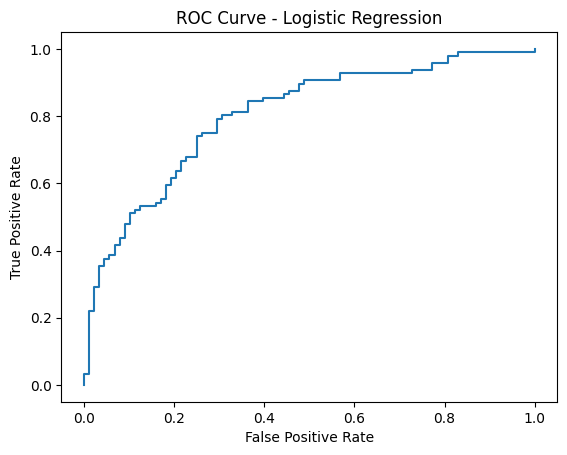

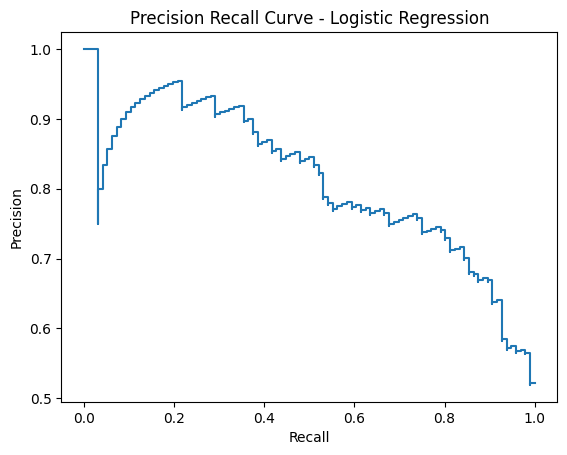

In [192]:
print(gslr.best_score_)
y_pred, y_pred_proba = get_results_model(gslr, X_test, y_test, "Logistic Regression")

export_plots(gslr, X_test, y_test, filename="movie_logistic_reg_ns", name="Logistic Regression")

In [193]:
transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),
    ("imputer", KNNImputer(), ['averageRating', 'numVotes', 'runtimeMinutes']),
    ("bagofw", CountVectorizer(min_df=0.01), 'genres')
    ],
    remainder='passthrough')

pipeline = Pipeline(
    steps=[
        ('transformer', transformer),
        ('standardizer', ScaleSwitcher(estimator=Normalizer)),
        ('clf', DecisionTreeClassifier(random_state=42))
    ]
)

parameters = [
    {
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [3,4,5,6,7],
        'standardizer__estimator':[Normalizer(), StandardScaler(), FunctionTransformer()]
    }
]

gscart1 = GridSearchCV(pipeline, parameters, cv=5, n_jobs = -1, verbose=0, scoring='roc_auc')
gscart1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         KNNImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
               

0.7795094627917882
CART AUC: 0.76497
CART F1: 0.73958
CART Accuracy: 0.72826


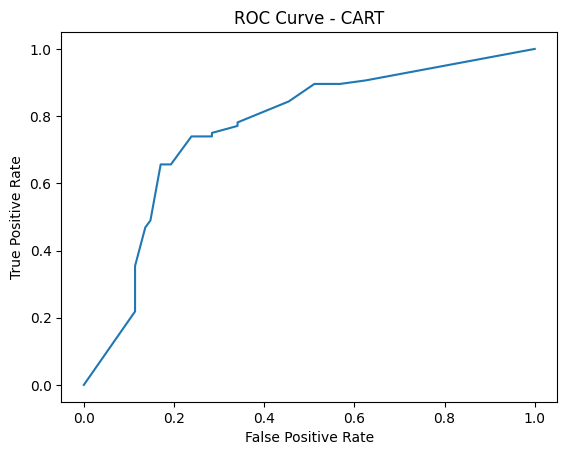

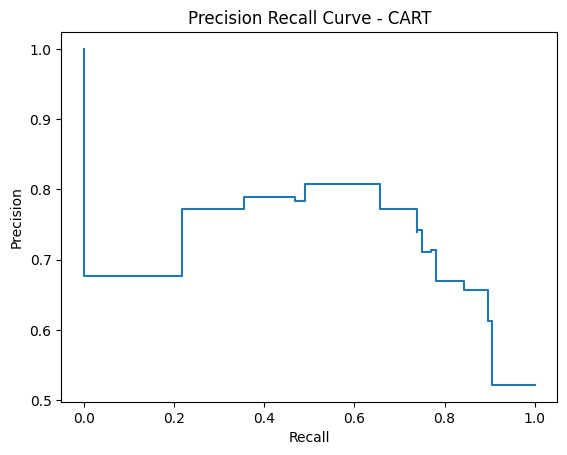

In [194]:
print(gscart.best_score_)
y_pred, y_pred_proba = get_results_model(gscart1, X_test, y_test, "CART")

export_plots(gscart1, X_test, y_test, "movie_cart_ns", "CART")

In [195]:
transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),
    ("imputer", KNNImputer(), ['averageRating', 'numVotes', 'runtimeMinutes']),
    ("bagofw", CountVectorizer(min_df=0.01), 'genres')
    ],
    remainder='passthrough')

pipeline = Pipeline(
    steps=[
        ('transformer', transformer),
        ('standardizer', ScaleSwitcher(estimator=Normalizer)),
        ('clf', RandomForestClassifier(random_state=42))
    ]
)

parameters = [

    {
        'clf__criterion': ['gini', 'entropy'],
        'clf__n_estimators': [10, 100, 200],
        'clf__max_depth': [3,4,5,6,7],
        'standardizer__estimator':[Normalizer(), StandardScaler(), FunctionTransformer()]
    }
]

gsrf1 = GridSearchCV(pipeline, parameters, cv=5, n_jobs = -1, verbose=0, scoring='roc_auc')
gsrf1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         KNNImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
               

0.8133244855324703
RF AUC: 0.82848
RF F1: 0.78641
RF Accuracy: 0.76087


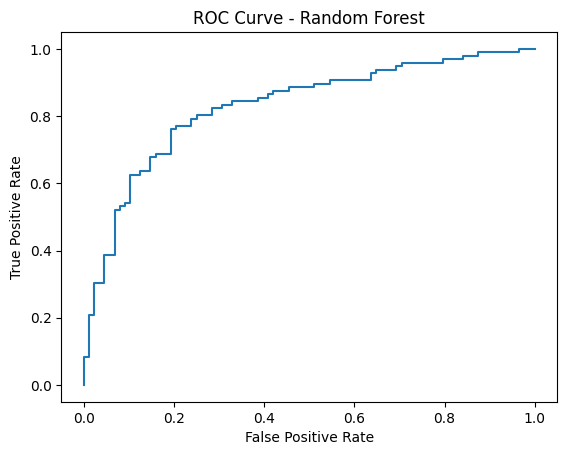

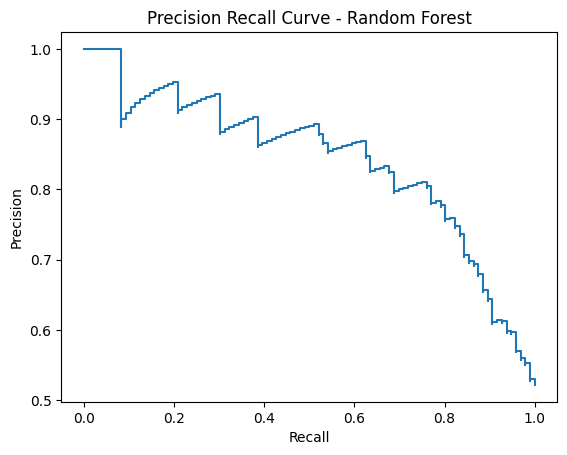

In [198]:
print(gsrf1.best_score_)
y_pred, y_pred_proba = get_results_model(gsrf1, X_test, y_test, "RF")
export_plots(gsrf1, X_test, y_test, "movie_random_forest_ns", "Random Forest")

In [200]:
from xgboost import XGBClassifier

transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),
    ("imputer", KNNImputer(), ['averageRating', 'numVotes', 'runtimeMinutes']),
    ("bagofw", CountVectorizer(min_df=0.01), 'genres'),
    ],
    remainder='passthrough')


pipeline = Pipeline(
    steps=[
        ('transformer', transformer),
        ('standardizer', ScaleSwitcher()),
        ('clf', XGBClassifier(random_state=42))
    ]
)

parameters = [

    {
        'clf__max_depth': [3, 4, 5],
        'clf__learning_rate': [0.01, 0.05, 0.1],
        'clf__n_estimators': [50, 100, 200],
        'clf__subsample': [0.8, 0.85, 0.9],
        'standardizer__estimator':[Normalizer(), StandardScaler(), FunctionTransformer()]
    }
]

gsxgb1 = GridSearchCV(pipeline, parameters, cv=5, n_jobs = -1, verbose=0, scoring='roc_auc')
gsxgb1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         KNNImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
               

0.8296838515714932
XGB AUC: 0.84233
XGB F1: 0.79592
XGB Accuracy: 0.78261


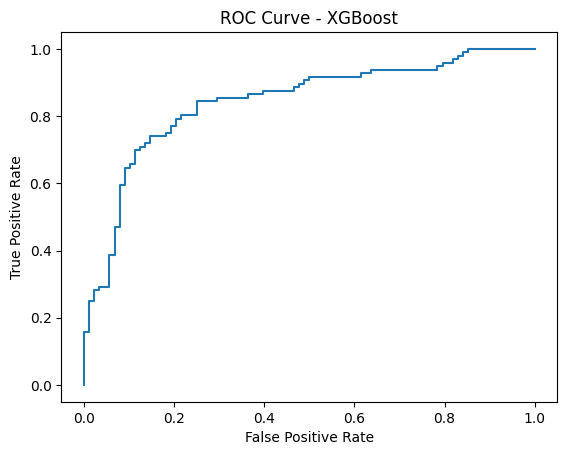

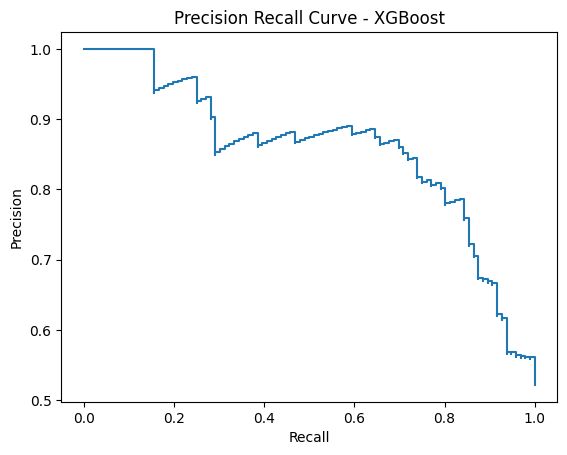

In [202]:
print(gsxgb1.best_score_)
y_pred, y_pred_proba = get_results_model(gsxgb1, X_test, y_test, "XGB")
export_plots(gsxgb1, X_test, y_test, "movie_xgboost_ns", "XGBoost")

## Rankings

In [203]:
drop_cols = ['combined_title', 'release_date', 'lower_title', 'season', 'is_tv_show', 'tconst', 'nudity', 'violence', 'profanity', 'alcohol', 'frightening', 'language',
       'summary', 'director_votes', 'writer_votes', 'actor_votes']

X_train, X_test, y_train, y_test = train_test_split(movies.drop(drop_cols + ['is_top10'], axis=1), movies['is_top10'], test_size=0.2, random_state=42, stratify=movies['is_top10'])


In [204]:
rankings_pipeline = Pipeline([

    ('imputer', KNNImputer()),
    ('logger', FunctionTransformer())
])


transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),
    ("imputer", KNNImputer(), ['averageRating', 'numVotes', 'runtimeMinutes']),
    ("bagofw", CountVectorizer(min_df=0.01), 'genres'),
    ("rankings_pipeline", rankings_pipeline, ['director_rank', 'writer_rank', 'actor_rank'])
    ],
    remainder='passthrough')


pipeline = Pipeline(
    steps=[
        ('transformer', transformer),
        ('standardizer', ScaleSwitcher()),
        ('clf', RandomForestClassifier(random_state=42))
    ]
)

parameters = [

    {
        'clf__criterion': ['gini', 'entropy'],
        'clf__n_estimators': [100, 200,300],
        'clf__max_depth': [6,7,8],
        'standardizer__estimator':[Normalizer(), StandardScaler(), FunctionTransformer()],
        'transformer__rankings_pipeline__logger__func':[np.log1p, np.sqrt, None]
    }
]

gsrf2 = GridSearchCV(pipeline, parameters, cv=5, n_jobs = -1, verbose=0, scoring='roc_auc')
gsrf2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         KNNImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
               

In [169]:
gsrf.best_params_

{'clf__criterion': 'entropy',
 'clf__max_depth': 8,
 'clf__n_estimators': 300,
 'standardizer__estimator': FunctionTransformer(),
 'transformer__rankings_pipeline__logger__func': <ufunc 'log1p'>}

0.8082667226874577
RF AUC: 0.81439
RF F1: 0.76699
RF Accuracy: 0.73913


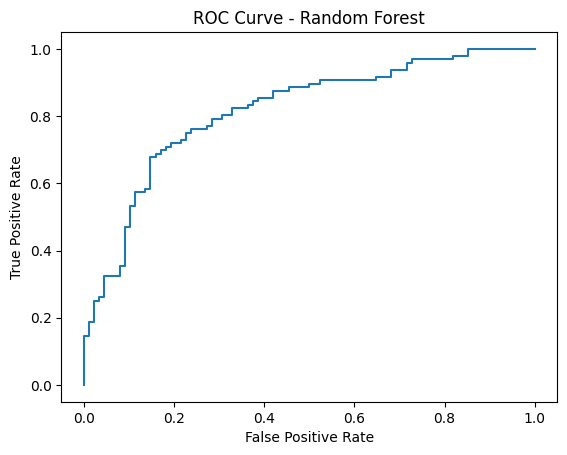

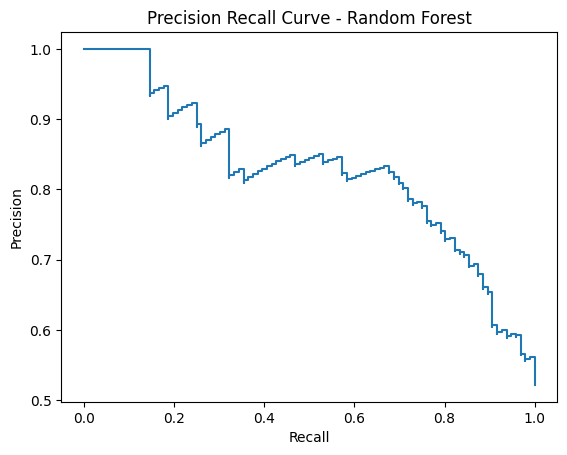

In [205]:
print(gsrf2.best_score_)
y_pred, y_pred_proba = get_results_model(gsrf2, X_test, y_test, "RF")
export_plots(gsrf2, X_test, y_test, "movie_random_forest_ranks_ns", "Random Forest")

In [206]:
from xgboost import XGBClassifier

rankings_pipeline = Pipeline([

    ('imputer', KNNImputer()),
    ('logger', FunctionTransformer())
])


transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),
    ("imputer", KNNImputer(), ['averageRating', 'numVotes', 'runtimeMinutes']),
    ("bagofw", CountVectorizer(min_df=0.01), 'genres'),
    ("rankings_pipeline", rankings_pipeline, ['director_rank', 'writer_rank', 'actor_rank'])
    ],
    remainder='passthrough')


pipeline = Pipeline(
    steps=[
        ('transformer', transformer),
        ('standardizer', ScaleSwitcher()),
        ('clf', XGBClassifier(random_state=42))
    ]
)

parameters = [

    {
        'clf__max_depth': [3, 4, 5],
        'clf__learning_rate': [0.01, 0.05, 0.1],
        'clf__n_estimators': [50, 100, 200],
        'clf__subsample': [0.8, 0.85, 0.9],
        'standardizer__estimator':[Normalizer(), StandardScaler(), FunctionTransformer()],
        'transformer__rankings_pipeline__logger__func':[np.log1p, np.sqrt, None]
    }
]

gsxgb2 = GridSearchCV(pipeline, parameters, cv=5, n_jobs = -1, verbose=0, scoring='roc_auc')
gsxgb2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         KNNImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
               

0.828735296261506
XGB AUC: 0.84422
XGB F1: 0.77778
XGB Accuracy: 0.76087


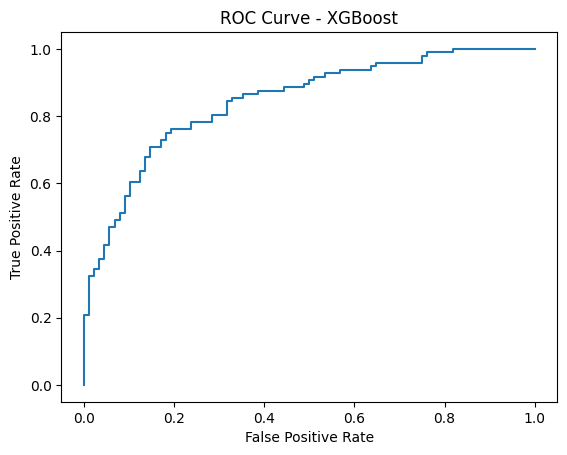

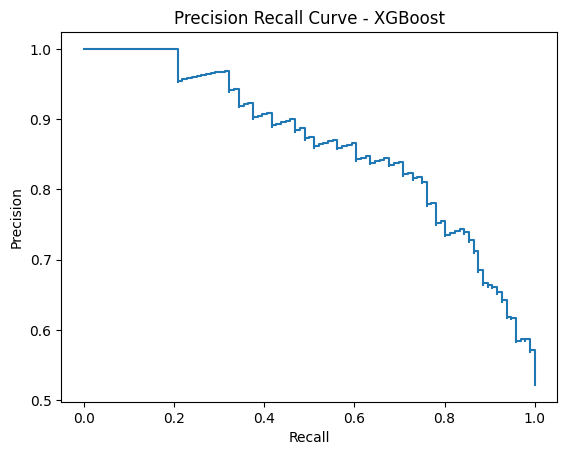

In [207]:
print(gsxgb2.best_score_)
y_pred, y_pred_proba = get_results_model(gsxgb2, X_test, y_test, "XGB")
export_plots(gsxgb2, X_test, y_test, "movie_xgboost_votes_ns", "XGBoost")

## Votes

In [209]:
drop_cols = ['combined_title', 'release_date', 'lower_title', 'season', 'is_tv_show', 'tconst', 'nudity', 'violence', 'profanity', 'alcohol', 'frightening', 'language',
       'summary', 'director_rank', 'writer_rank', 'actor_rank']

X_train, X_test, y_train, y_test = train_test_split(movies.drop(drop_cols + ['is_top10'], axis=1), movies['is_top10'], test_size=0.2, random_state=42, stratify=movies['is_top10'])


In [210]:
rankings_pipeline = Pipeline([

    ('imputer', KNNImputer()),
    ('logger', FunctionTransformer())
])


transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),
    ("imputer", KNNImputer(), ['averageRating', 'numVotes', 'runtimeMinutes']),
    ("bagofw", CountVectorizer(min_df=0.01), 'genres'),
    ("rankings_pipeline", rankings_pipeline, ['director_votes', 'writer_votes', 'actor_votes'])
    ],
    remainder='passthrough')


pipeline = Pipeline(
    steps=[
        ('transformer', transformer),
        ('standardizer', ScaleSwitcher()),
        ('clf', RandomForestClassifier(random_state=42))
    ]
)

parameters = [

    {
        'clf__criterion': ['gini', 'entropy'],
        'clf__n_estimators': [100, 200,300],
        'clf__max_depth': [6,7,8],
        'standardizer__estimator':[Normalizer(), StandardScaler(), FunctionTransformer()],
        'transformer__rankings_pipeline__logger__func':[np.log1p, np.sqrt, None]
    }
]

gsrf3 = GridSearchCV(pipeline, parameters, cv=5, n_jobs = -1, verbose=0, scoring='roc_auc')
gsrf3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         KNNImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
               

In [211]:
gsrf3.best_params_

{'clf__criterion': 'entropy',
 'clf__max_depth': 8,
 'clf__n_estimators': 300,
 'standardizer__estimator': FunctionTransformer(),
 'transformer__rankings_pipeline__logger__func': <ufunc 'sqrt'>}

0.8097310864503495
RF AUC: 0.83061
RF F1: 0.78846
RF Accuracy: 0.76087


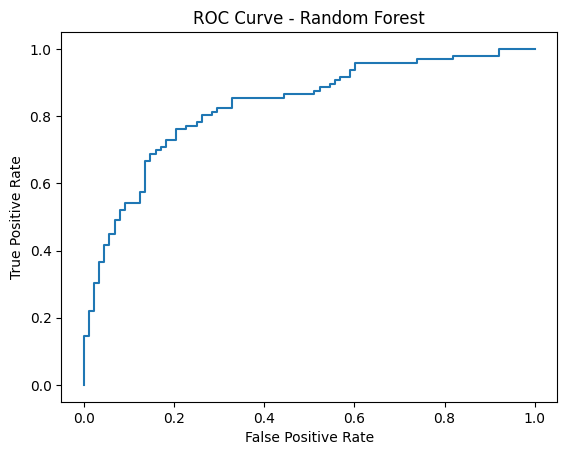

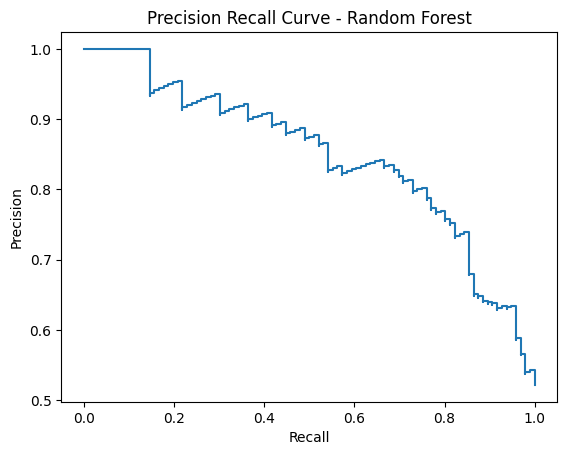

In [212]:
print(gsrf3.best_score_)
y_pred, y_pred_proba = get_results_model(gsrf3, X_test, y_test, "RF")
export_plots(gsrf3, X_test, y_test, "movie_random_forest_votes_ns", "Random Forest")

In [213]:
from xgboost import XGBClassifier

rankings_pipeline = Pipeline([

    ('imputer', KNNImputer()),
    ('logger', FunctionTransformer())
])


transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),
    ("imputer", KNNImputer(), ['averageRating', 'numVotes', 'runtimeMinutes']),
    ("bagofw", CountVectorizer(min_df=0.01), 'genres'),
    ("rankings_pipeline", rankings_pipeline, ['director_votes', 'writer_votes', 'actor_votes'])
    ],
    remainder='passthrough')


pipeline = Pipeline(
    steps=[
        ('transformer', transformer),
        ('standardizer', ScaleSwitcher()),
        ('clf', XGBClassifier(random_state=42))
    ]
)

parameters = [

    {
        'clf__max_depth': [3, 4, 5],
        'clf__learning_rate': [0.01, 0.05, 0.1],
        'clf__n_estimators': [50, 100, 200],
        'clf__subsample': [0.8, 0.85, 0.9],
        'standardizer__estimator':[Normalizer(), StandardScaler(), FunctionTransformer()],
        'transformer__rankings_pipeline__logger__func':[np.log1p, np.sqrt, None]
    }
]

gsxgb3 = GridSearchCV(pipeline, parameters, cv=5, n_jobs = -1, verbose=0, scoring='roc_auc')
gsxgb3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         KNNImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
               

0.8281560862096707
XGB AUC: 0.85736
XGB F1: 0.80402
XGB Accuracy: 0.78804


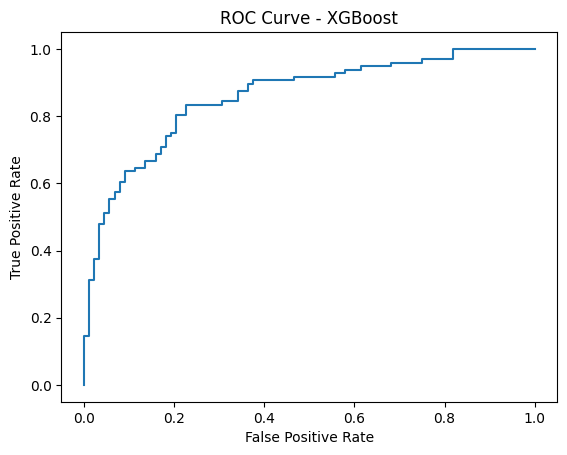

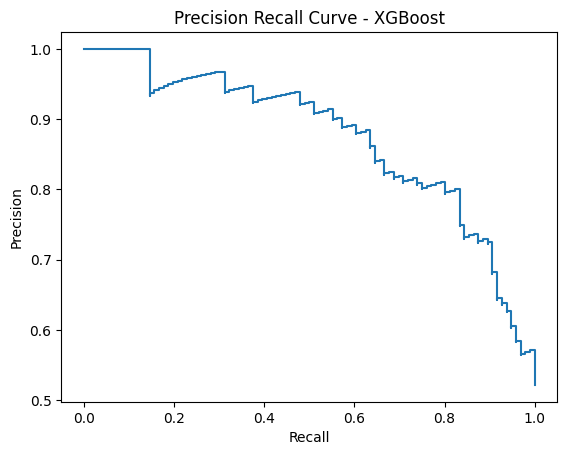

In [214]:
print(gsxgb3.best_score_)
y_pred, y_pred_proba = get_results_model(gsxgb3, X_test, y_test, "XGB")
export_plots(gsxgb3, X_test, y_test, "movie_xgboost_votes_ns", "XGBoost")